In [1]:
# import essential libs
from random import random

from pyclustering.utils import read_sample
from pyclustering.samples.definitions import FCPS_SAMPLES
from pyclustering.cluster.rock import rock
from pyclustering.cluster.kmeans import kmeans
from pyclustering.cluster import cluster_visualizer,cluster_visualizer_multidim
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

import matplotlib.pyplot as plt
import numpy as np

In [15]:
# external util functions and constant definitioin
NUM_CLUSTERS = 2
THETA = 0.5
DATA_SAMPLE_PATH = './data_examples/market_basket_data_samples_2.txt'
GROUND_TRUTH_CLUSTER_INDEX_FOR_SAMPLE_2 = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [10, 11, 12, 13]]
VERBOSE = True
MATRIX_VERBOSE = False
COLORS = ['r', 'g', 'b', 'y']
SHAPES = ['o-', 's-', 'v-']

def print_clusters(data, clusters):
    clusters_data = []
    for i in range(len(clusters)):
        cluster_data = []
        for j in clusters[i]:
            cluster_data.append([int(k) for k in data[j]])
        clusters_data.append(cluster_data)
        print(f"=> Cluster {i}: {cluster_data}")
    return clusters_data

def onehot_converter(data, onehot_len):
    onehot_data = []
    for transaction in data:
        onehot_transaction = [0 for i in range(onehot_len)]
        for item in transaction:   
            onehot_transaction[int(item)-1] = 1
        onehot_data.append(onehot_transaction)
    return onehot_data

def visualize_clusters(data, clusters):
    visualizer = cluster_visualizer()
    visualizer.append_clusters(clusters, data)
    visualizer.show()

def clustering_by_rock(data_sample_path, num_clusters, theta, matrix_verbose):
    data = read_sample(data_sample_path)
    # ROCK instance initialization and clustering
    rock_instance = rock(data, num_clusters, theta=theta, matrix_verbose=matrix_verbose)
    rock_instance.process()
    clusters = rock_instance.get_clusters()
    goodness_per_cluster = rock_instance.get_goodness_per_cluster()
    if VERBOSE == True:
        print(f"==> ROCK Clustering Results by {theta}...")
        print_clusters(data, clusters)
    clusters_correct_num = []
    if len(clusters) == 2:
        for i in range(num_clusters):
            cluster = clusters[i]
            clusters_correct_num.append(len(set(cluster).intersection(set(GROUND_TRUTH_CLUSTER_INDEX_FOR_SAMPLE_2[i]))))
    else: # possibly > 2
        max_intersect_for_cluster_2 = 0
        for i in range(len(clusters)):
            cluster = clusters[i]
            intersect = len(set(cluster).intersection(set(GROUND_TRUTH_CLUSTER_INDEX_FOR_SAMPLE_2[1 if i > 1 else i])))
            if i < 1:
                clusters_correct_num.append(intersect)
            else:
                if max_intersect_for_cluster_2 < intersect:
                    max_intersect_for_cluster_2 = intersect
        clusters_correct_num.append(max_intersect_for_cluster_2)    
                    
    assert len(clusters_correct_num) == 2
    if VERBOSE == True:
        print(f"===> Clusters Indexes: {clusters}")
        print(f"===> Corrects {clusters_correct_num}")
        print()
    precisions = [ cluster_correct_num / float(len(clusters[i])) * 100 for (i, cluster_correct_num) in enumerate(clusters_correct_num) ]
    recalls = [ cluster_correct_num / float(len(GROUND_TRUTH_CLUSTER_INDEX_FOR_SAMPLE_2[i])) * 100 for (i, cluster_correct_num) in enumerate(clusters_correct_num) ]
    f1s = [ 2*precision*recall/(precision+recall) for precision, recall in zip(precisions, recalls) ]
    return precisions, recalls, f1s, goodness_per_cluster
           

def clustering_by_kmeans(data_sample_path):
    data = read_sample(data_sample_path)
    if DATA_SAMPLE_PATH == './data_examples/market_basket_data_samples_1.txt':
        onehot_data = onehot_converter(data, 6) 
    else:
        onehot_data = onehot_converter(data, 7) 
    # print(f"onehot_data: {onehot_data}")
    print("==> KMeans Clustering Results...")
    # create instance of K-Means algorithm
    if DATA_SAMPLE_PATH == './data_examples/market_basket_data_samples_1.txt':
        kmeans_instance = kmeans(onehot_data, [ [1, 1, 1, 0, 1, 0], [0, 0, 0, 0, 0, 1] ])
    else:
        kmeans_instance = kmeans(onehot_data, [ [1, 1, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 1, 1] ])
    # run cluster analysis and obtain results
    kmeans_instance.process()
    clusters = kmeans_instance.get_clusters()
    print_clusters(data, clusters)

def clustering_by_kmeans_plus_plus(data_sample_path):
    data = read_sample(data_sample_path)
    if DATA_SAMPLE_PATH == './data_examples/market_basket_data_samples_1.txt':
        onehot_data = onehot_converter(data, 6) 
    else:
        onehot_data = onehot_converter(data, 7) 
    print("==> KMeans++ Clustering Results...")
    # initialize initial centers using K-Means++ method
    initial_centers = kmeans_plusplus_initializer(onehot_data, 2).initialize()
    # create instance of K-Means algorithm with prepared centers
    kmeans_instance = kmeans(onehot_data, initial_centers)
    # run cluster analysis and obtain results
    kmeans_instance.process()
    clusters = kmeans_instance.get_clusters()
    # final_centers = kmeans_instance.get_centers()
    print_clusters(data, clusters)
    
def theta_ablation_study(num_thetas):
    # matplotlib theta ablation experiments for testing robustness
    THETAS = np.linspace(0., 0.5, num_thetas)
    precisions, recalls, f1s, goodness_per_clusters, goodness_all_clusterss = [], [], [], [], []
    for i in range(NUM_CLUSTERS):
        precisions.append([])
        recalls.append([])
        f1s.append([])
        goodness_per_clusters.append([])
    for THETA in THETAS:
        precision, recall, f1, goodness_per_cluster = clustering_by_rock(DATA_SAMPLE_PATH, NUM_CLUSTERS, THETA, MATRIX_VERBOSE)
        goodness_all_clusterss.append(0)
        for i in range(NUM_CLUSTERS):
            precisions[i].append(precision[i])
            recalls[i].append(recall[i])
            f1s[i].append(f1[i])
            goodness_per_clusters[i].append(goodness_per_cluster[i])
    for i in range(NUM_CLUSTERS):
        plt.plot(THETAS, precisions[i], color=COLORS[i%len(COLORS)], label=f"Cluster {i} Precision")
    plt.xlabel("Theta")
    plt.ylabel("Precision Per Cluster")
    plt.legend(loc = "best")
    plt.title(f"Theta's Impact for ROCK Clustering")
    plt.show()
    
    for i in range(NUM_CLUSTERS):
        plt.plot(THETAS, recalls[i], color=COLORS[i%len(COLORS)], label=f"Cluster {i} Recall")
    plt.xlabel("Theta")
    plt.ylabel("Recall Per Cluster")
    plt.legend(loc = "best")
    plt.title(f"Theta's Impact ROCK Clustering")
    plt.show()
    
    for i in range(NUM_CLUSTERS):
        plt.plot(THETAS, f1s[i], color=COLORS[i%len(COLORS)], label=f"Cluster {i} F1")
    plt.xlabel("Theta")
    plt.ylabel("F1 Per Cluster")
    plt.legend(loc = "best")
    plt.title(f"Theta's Impact for ROCK Clustering")
    plt.show()
    
    for i in range(NUM_CLUSTERS):
        plt.plot(THETAS, goodness_per_clusters[i], color=COLORS[i%len(COLORS)], label=f"Cluster {i} Goodness")
        goodness_all_clusterss = [ all_clusters+per_cluster for all_clusters, per_cluster in zip(goodness_all_clusterss, goodness_per_clusters[i]) ]
    goodness_all_clusterss =  [ goodness_all_clusters/NUM_CLUSTERS for goodness_all_clusters in goodness_all_clusterss ]
    plt.plot(THETAS, goodness_all_clusterss, color=COLORS[(i+1)%len(COLORS)], label=f"All Clusters Average Goodness")
    plt.xlabel("Theta")
    plt.ylabel("Goodness")
    plt.legend(loc = "best")
    plt.title(f"Theta's Impact for ROCK Clustering")
    plt.show()

==> ROCK Clustering Results by 0.0...
=> Cluster 0: [[1, 2, 3], [1, 2, 4], [1, 2, 5], [1, 3, 4], [1, 6, 7], [2, 6, 7]]
=> Cluster 1: [[1, 3, 5], [1, 4, 5], [2, 3, 4], [2, 3, 5], [2, 4, 5], [3, 4, 5], [1, 2, 6], [1, 2, 7]]
===> Clusters Indexes: [[0, 1, 2, 3, 12, 13], [4, 5, 6, 7, 8, 9, 10, 11]]
===> Corrects [4, 2]

==> ROCK Clustering Results by 0.00010002000400080016...
=> Cluster 0: [[1, 2, 3], [1, 2, 4], [1, 2, 5], [1, 3, 4], [2, 3, 4], [2, 3, 5], [2, 4, 5], [1, 6, 7]]
=> Cluster 1: [[1, 3, 5], [1, 4, 5], [2, 6, 7], [3, 4, 5], [1, 2, 6], [1, 2, 7]]
===> Clusters Indexes: [[0, 1, 2, 3, 6, 7, 8, 12], [4, 5, 13, 9, 10, 11]]
===> Corrects [7, 3]

==> ROCK Clustering Results by 0.00020004000800160032...
=> Cluster 0: [[1, 2, 3], [1, 2, 4], [1, 2, 5], [1, 3, 4], [2, 3, 4], [2, 3, 5], [2, 4, 5], [1, 6, 7]]
=> Cluster 1: [[1, 3, 5], [1, 4, 5], [2, 6, 7], [3, 4, 5], [1, 2, 6], [1, 2, 7]]
===> Clusters Indexes: [[0, 1, 2, 3, 6, 7, 8, 12], [4, 5, 13, 9, 10, 11]]
===> Corrects [7, 3]

==> ROCK

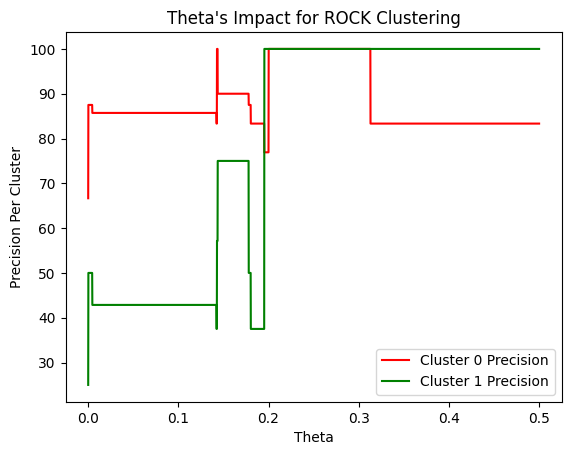

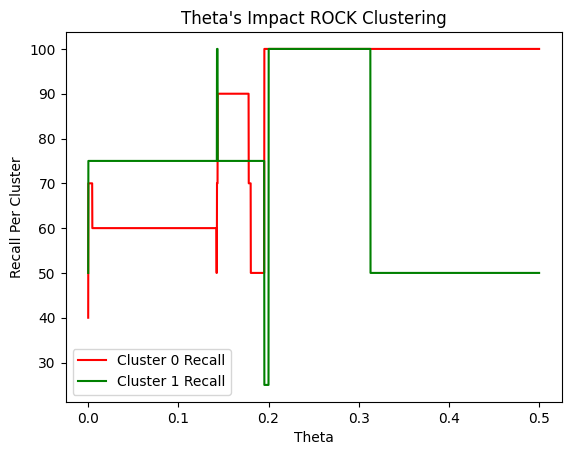

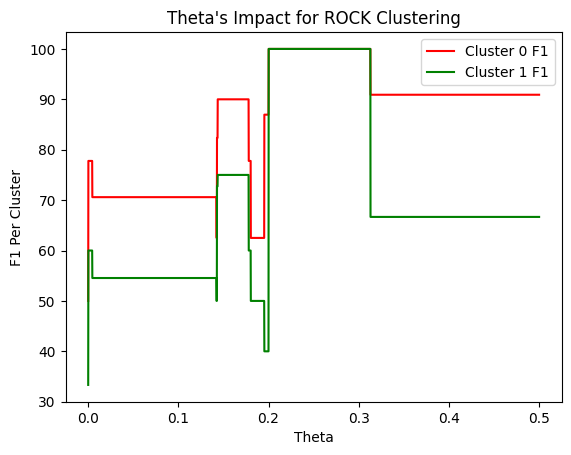

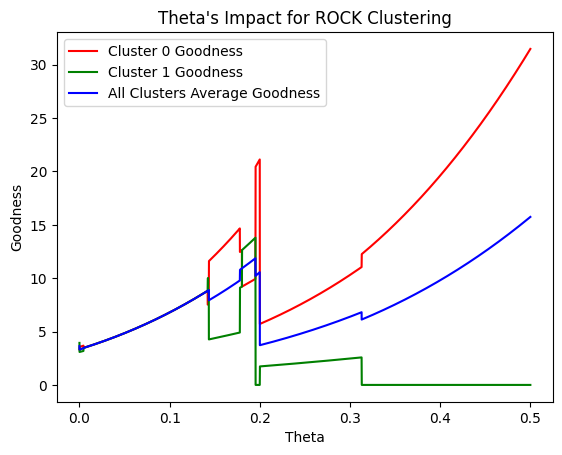

In [16]:
theta_ablation_study(5000)
# theta_ablation_study(1000)

In [66]:
# clustering codes by rock, kmeans, kmeans++
clustering_by_kmeans(DATA_SAMPLE_PATH)
clustering_by_kmeans_plus_plus(DATA_SAMPLE_PATH)

==> KMeans Clustering Results...
=> Cluster 0: [[1, 2, 3], [1, 2, 4], [1, 2, 5], [1, 3, 4], [1, 3, 5], [1, 4, 5], [2, 3, 4], [2, 3, 5], [2, 4, 5], [3, 4, 5]]
=> Cluster 1: [[1, 2, 6], [1, 2, 7], [1, 6, 7], [2, 6, 7]]
==> KMeans++ Clustering Results...
=> Cluster 0: [[1, 2, 5], [1, 3, 4], [1, 3, 5], [1, 4, 5], [2, 3, 4], [2, 3, 5], [2, 4, 5], [3, 4, 5]]
=> Cluster 1: [[1, 2, 3], [1, 2, 4], [1, 2, 6], [1, 2, 7], [1, 6, 7], [2, 6, 7]]


[[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1

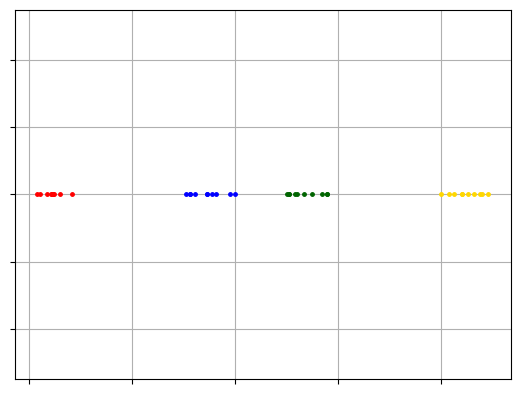

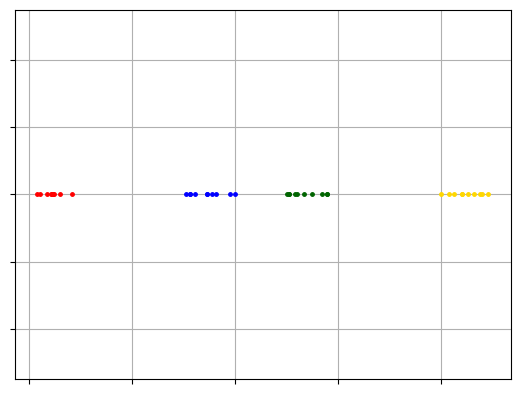

In [2]:
# random data example generatoin
data = [ [random()] for i in range(10) ] + [ [random() + 3] for i in range(10) ] + [ [random() + 5] for i in range(10) ] + [ [random() + 8] for i in range(10) ]

# ROCK instance initializatioin and clustering sampled data
rock_instance = rock(data, 1.0, 4, 0.5)
rock_instance.process()
clusters = rock_instance.get_clusters()

# visualize by pyclustering
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, data)
visualizer.show()

[[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

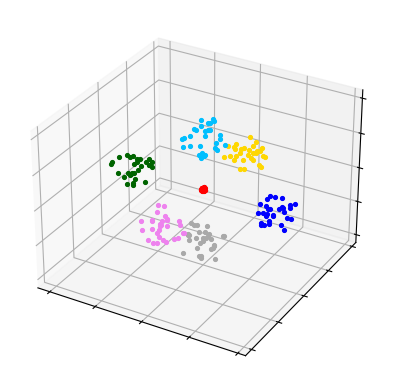

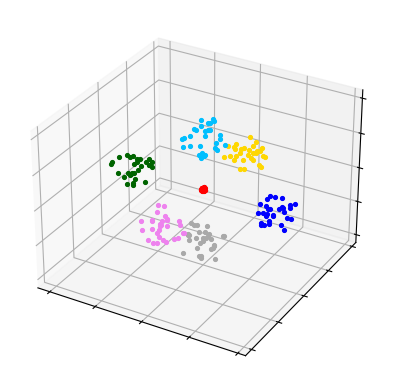

In [3]:
# data sampling by pyclustering implemented FCPS_SAMPLES.SAMPLE_HEPTA mode
data = read_sample(FCPS_SAMPLES.SAMPLE_HEPTA)

# ROCK instance initialization and clustering
rock = rock(data, 1.0, 7)
rock.process()
clusters = rock.get_clusters()

# visualize by pyclusetering
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, data)
visualizer.show()

> Reference: [Hands-On Guide To ROCK Clustering Algorithm](https://analyticsindiamag.com/hands-on-guide-to-rock-clustering-algorithm/)